In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
np.random.seed(1992) # para replicabilidad

***Importación de datos basa en:*** <br>
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [3]:
precio_soya = pd.read_csv('soybean-prices.csv', sep= ',', index_col= 0, skiprows=3, parse_dates = True)

### Visualizar la base de datos

In [4]:
precio_soya.head()

,P_soya
date,
2017-01-03,9.9500
2017-01-04,10.1525
2017-01-05,10.1250
2017-01-06,9.9475
2017-01-09,10.0525


In [5]:
precio_soya.tail()

,P_soya
date,
2019-06-14,8.9675
2019-06-17,9.1275
2019-06-18,9.1350
2019-06-19,9.0325
2019-06-20,9.1550


In [6]:
precio_soya.describe()

,P_soya
count,621.000000
mean,9.433614
std,0.659359
min,8.025000
25%,8.905000
50%,9.467500
75%,9.947500
max,10.775000


### Gráfica de los datos en niveles

Text(0.5, 1.0, 'Precio del a soya')

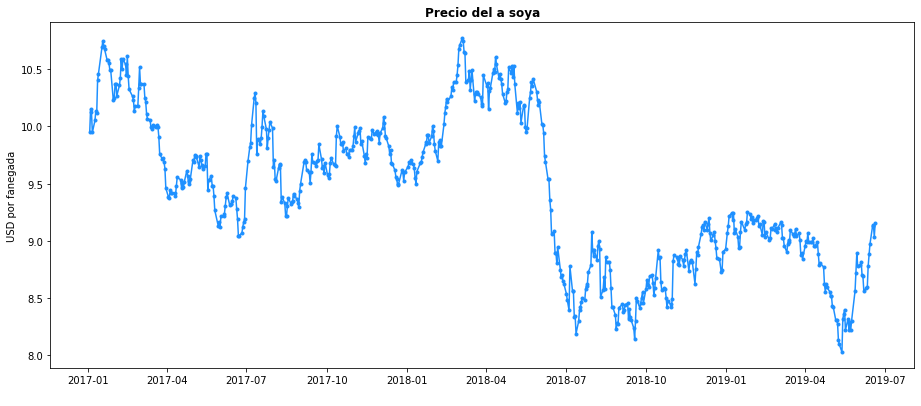

In [7]:
f1 = plt.figure(figsize=(15, 6))
ax1 = f1.add_axes([0.1,0.1,0.8,0.8])

ax1.set_facecolor('white')
ax1.plot(precio_soya['P_soya'], linestyle='-', marker='.' ,color='dodgerblue')
ax1.set_facecolor('white')
ax1.set_ylabel('USD por fanegada');
ax1.set_xlabel(' ');
ax1.set_title('Precio del a soya', fontweight='bold')


### Encontrar retornos log del precio del maíz

In [8]:
# Crear variable de retornos e incluirla en el dataframe de pandas
ret_log = pd.DataFrame()
ret_log['Precio'] = np.log(precio_soya['P_soya']).diff().dropna()
ret_log.head()

,Precio
date,
2017-01-04,0.020147
2017-01-05,-0.002712
2017-01-06,-0.017686
2017-01-09,0.010500
2017-01-10,0.008420


In [9]:
retorno = ret_log['Precio'].mean()
volatilidad = ret_log['Precio'].std()

# Distribución de los retornos del precio de la soya

Text(0.5, 1.0, 'Histograma de Retornos del precio de la soya: $\\mu=$-0.00013, $\\sigma=$0.0107')

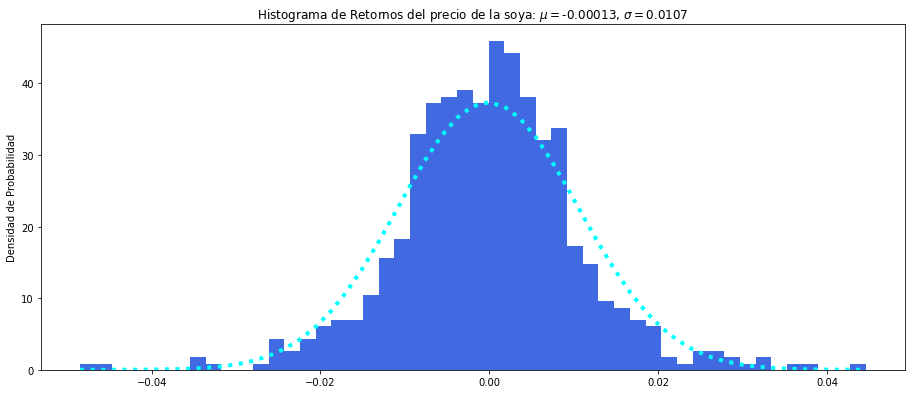

In [10]:
f2 = plt.figure(figsize=(15, 6))
ax2 = f2.add_axes([0.1,0.1,0.8,0.8])
ax2.set_facecolor('white')
n, bins, patches = ax2.hist(ret_log['Precio'], 50, density=True, histtype='stepfilled', color='royalblue')
y = ((1 / (np.sqrt(2 * np.pi) * volatilidad)) *
        np.exp(-0.5 * (1 / volatilidad * (bins - retorno))**2)) 
# Esto lo hace para graficar una dist normal con m y sd de la muestra de retornos, para comparación
ax2.plot(bins, y, ':', color='cyan', linewidth='4')

ax2.set_xlabel('')
ax2.set_ylabel('Densidad de Probabilidad')
ax2.set_title('Histograma de Retornos del precio de la soya: $\mu=$' +
             "{:,.5f}".format(retorno) +', $\sigma=$' + "{:,.4f}".format(volatilidad))

### Simulación de los precios de la soya

In [11]:
# arreglo de fechas
start = datetime.date(2019, 6, 20)
end = datetime.date(2019, 12, 31)
holidays = ['2019-12-24', datetime.date(2019, 12, 25), np.datetime64('2019-12-26')]
fechas = pd.bdate_range(start = start, end = end, freq = 'C', holidays = holidays)
fechas

DatetimeIndex(['2019-06-20', '2019-06-21', '2019-06-24', '2019-06-25',
               '2019-06-26', '2019-06-27', '2019-06-28', '2019-07-01',
               '2019-07-02', '2019-07-03',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=136, freq='C')

**Obs:**
El modelo de simulación se define por:
<br><br>
$$
retornos_{i, sim} = \bar{R}_{soya} + X_{i} * vol_{soya}
$$
<br>
Donde $\bar{R}$ y $vol{ret}$, son el promedio y la volatilidad de los retornos de los precios de la soya, respectivamente. La variable $X_{i}$ se obtiene de draws aleatorios provenientes de la distrbiución normal estándar.

In [12]:
# simulación de las variaciones en los precios de la soya
num_dias = len(fechas)
num_sims = 10000

## Definir Matriz de simulaciones
sims = np.zeros((num_dias,num_sims))

## Definir Matriz de retornos aleatorios
ret = np.random.randn(num_dias , num_sims) * volatilidad + retorno

## Definir el primer flujo como el ahorro inicial
sims[0,] = np.exp(ret[0,]) * precio_soya['P_soya'].iloc[-1]


for i in range(1,num_dias):
    sims[i,] = sims[i-1,] * np.exp(ret[i,])

In [13]:
# Función definida para graficar
def graficar_percentiles_df(df):
    f = plt.figure(figsize=(17, 4))
    ax = plt.subplot(1, 2, 1)
    ax.plot(df.quantile(0.05, axis = 1), color = 'r', linewidth=4)
    ax.plot(df.mean(axis = 1), color = 'b', linewidth=4)
    ax.plot(df.quantile(0.95, axis = 1), color = 'g', linewidth=4)
    ax.plot(df.iloc[:,0:20], color = 'k' , alpha=0.15)
    ax.set_title('Utilidades Simuladas Mes a Mes')
    
    ax2 = plt.subplot(1, 2, 2)
    n, bins, patches = ax2.hist(df.sum(), 50, density=True)
    ax2.set_xlabel('Utilidades')
    ax2.set_ylabel('Densidad de Probabilidad')
    ax2.set_title('Histograma de Utilidad Anual. $EaR_{[90]} = $' + "{:,.1f}".format(df.sum().quantile(0.1)))
    ax2.axvline(x=df.sum().quantile(0.1), color='r')

In [14]:
percentil05 = np.percentile(sims,5,axis = 1)
percentil95 = np.percentile(sims,95,axis = 1)
promedio = sims.mean(axis = 1)

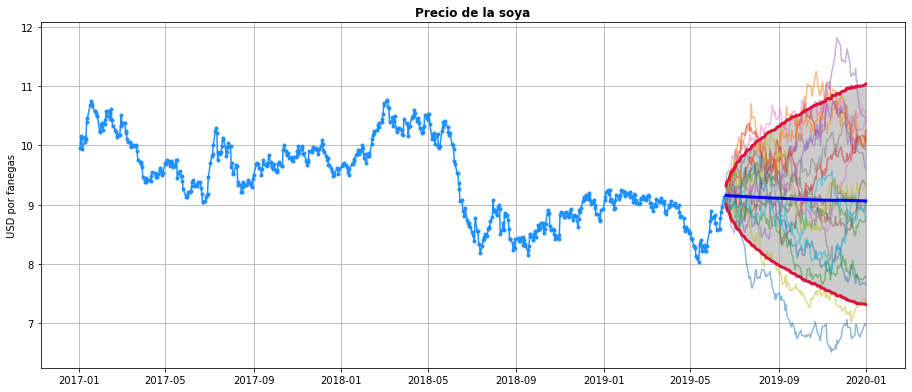

In [15]:
f3 = plt.figure(figsize=(15, 6))
ax3 = f3.add_axes([0.1,0.1,0.8,0.8])

ax3.set_facecolor('white')
ax3.plot(precio_soya['P_soya'], linestyle='-', marker='.' ,color='dodgerblue')
ax3.plot(fechas,sims[:,0:20], alpha=0.5)
plt.fill_between(fechas, percentil05, percentil95, where = percentil05 <= percentil95, color = 'grey', alpha = 0.4)
ax3.plot(fechas, percentil05, color = 'crimson', linewidth=3)
ax3.plot(fechas, promedio, color = 'blue', linewidth=3)
ax3.plot(fechas, percentil95, color = 'crimson', linewidth=3)
ax3.set_ylabel('USD por fanegas')
ax3.set_title('Precio de la soya', fontweight='bold')
ax3.grid(True)

### Calcular promedios diarios mes a mes del precio de la soya

In [16]:
sims_df =  pd.DataFrame(sims, index = fechas).resample('M').mean()#.to_numpy()
sims_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2019-06-30,8.964635,9.186083,9.310852,9.290306,9.280148,9.274267,9.448828,9.378327,9.050171,9.220071,...,9.415723,9.248767,9.149968,9.064807,9.403188,9.068660,9.392320,9.125254,9.270547,8.972232
2019-07-31,8.275916,9.434267,9.486871,9.557909,9.300218,8.972404,9.979335,9.820420,8.743062,8.986787,...,8.781426,8.732585,9.307635,9.220216,9.363625,9.451086,9.302062,9.095884,9.375408,8.947532
2019-08-31,7.724060,9.769900,9.464458,9.752057,9.603119,9.379898,10.355618,9.656443,8.138089,9.515152,...,8.534426,9.066092,9.463986,9.312256,8.955850,9.360926,9.150405,8.865218,9.962393,9.139211
2019-09-30,7.103272,10.348850,9.105724,9.882073,9.757850,9.081350,10.406709,9.527251,7.661924,8.640097,...,8.680697,9.368422,8.775474,9.314899,8.477151,8.782406,9.181650,8.787736,10.254425,8.722970
2019-10-31,6.830765,10.886807,8.751018,10.427437,10.136473,9.156454,10.631781,9.031055,7.444368,9.004325,...,8.940366,8.594882,8.815530,9.269195,8.152507,8.802755,9.200488,9.318935,10.144931,9.355573
2019-11-30,6.718351,10.717527,8.910714,10.744393,11.228684,9.136722,10.651695,8.247712,7.395763,9.300760,...,9.468250,8.210076,8.397511,9.265595,8.229047,9.165805,9.401344,9.602326,10.228796,10.035746
2019-12-31,6.897691,10.188676,8.694226,10.172327,11.122723,9.054817,10.344601,8.836521,7.218452,8.990667,...,9.444056,7.801275,7.795474,8.887913,7.671633,9.156951,8.934964,8.713517,10.520512,9.847927


## Precios del Maíz
Los datos se van a extraer directamente de yahoo-finance (https://finance.yahoo.com/quote/CORN/history?p=CORN), y se va a utilizar el precio de cierre [Close*].

Para poder instalar datos de yahoo-finance se debe instalar yfinance (https://pypi.org/project/fix-yahoo-finance/)

In [17]:
from pandas_datareader import data as pdr
import yfinance as yf

In [18]:
fech_ini= '2017-04-23'
fech_fin= '2019-06-20'
precio_maiz = pdr.get_data_yahoo('CORN', start=fech_ini, end=fech_fin)

In [19]:
#precio_maiz = pd.read_csv('CORN.csv', sep= ',', index_col= 0, skiprows=0, parse_dates = True)

In [20]:
precio_maiz.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-04-24,18.740000,18.549999,18.680000,18.680000,65400,18.680000
2017-04-25,19.100000,18.559999,18.559999,18.950001,93700,18.950001
2017-04-26,19.080000,18.700001,19.059999,18.709999,30900,18.709999
2017-04-27,18.930000,18.740000,18.790001,18.790001,37500,18.790001
2017-04-28,18.780001,18.600000,18.780001,18.709999,22300,18.709999


In [21]:
precio_maiz.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-06-14,17.320000,17.110001,17.120001,17.250000,323400,17.250000
2019-06-17,17.549999,17.270000,17.549999,17.410000,436300,17.410000
2019-06-18,17.400000,17.150000,17.240000,17.209999,249600,17.209999
2019-06-19,17.180000,16.860001,17.150000,16.940001,214300,16.940001
2019-06-20,17.180000,16.930000,16.980000,17.170000,143300,17.170000


In [22]:
precio_maiz.describe()

,High,Low,Open,Close,Volume,Adj Close
count,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,17.130165,16.943897,17.039614,17.032353,84718.933824,17.032353
std,1.124768,1.105665,1.114524,1.112781,80959.059237,1.112781
min,14.780000,14.380000,14.440000,14.670000,7400.000000,14.670000
25%,16.290001,16.137499,16.217499,16.207500,36850.000000,16.207500
50%,16.935000,16.765000,16.840000,16.825000,57750.000000,16.825000
75%,17.840000,17.680000,17.809999,17.760000,97675.000000,17.760000
max,20.049999,19.850000,19.879999,19.990000,743000.000000,19.990000


Text(0.5, 1.0, 'Precio del maiz')

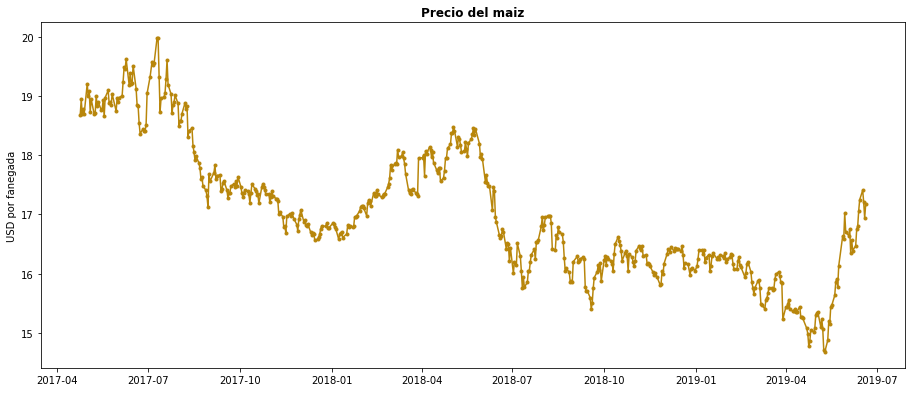

In [23]:
f8 = plt.figure(figsize=(15, 6))
ax8 = f8.add_axes([0.1,0.1,0.8,0.8])

ax8.set_facecolor('white')
ax8.plot(precio_maiz['Close'], linestyle='-', marker='.' ,color='darkgoldenrod')
ax8.set_facecolor('white')
ax8.set_ylabel('USD por fanegada');
ax8.set_xlabel(' ');
ax8.set_title('Precio del maiz', fontweight='bold')


## Retornos log del precio del maíz

In [24]:
# Crear variable de retornos e incluirla en el dataframe de pandas
ma_ret_log = pd.DataFrame()
ma_ret_log['Precio'] = np.log(precio_maiz['Close']).diff().dropna()
ma_ret_log.head()

,Precio
Date,
2017-04-25,0.014351
2017-04-26,-0.012746
2017-04-27,0.004267
2017-04-28,-0.004267
2017-05-01,0.026373


In [25]:
ma_retorno = ma_ret_log['Precio'].mean()
ma_volatilidad = ma_ret_log['Precio'].std()

# Distribución de los retornos del precio del maíz

Text(0.5, 1.0, 'Histograma de Retornos del precio de la soya: $\\mu=$-0.00016, $\\sigma=$0.0098')

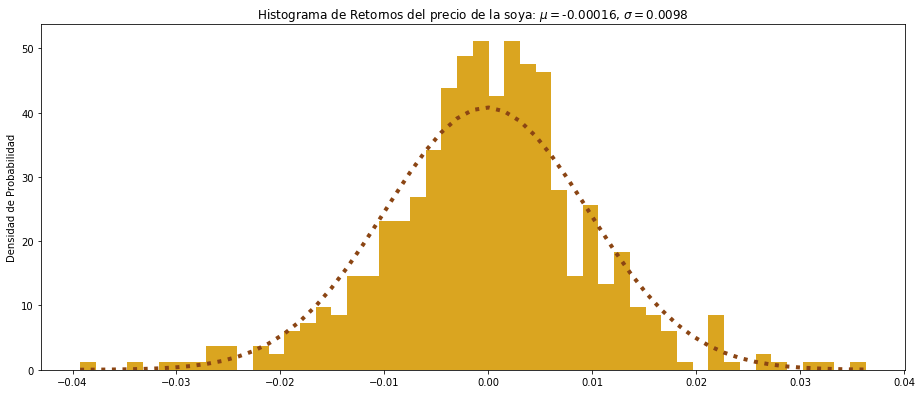

In [26]:
f2 = plt.figure(figsize=(15, 6))
ax2 = f2.add_axes([0.1,0.1,0.8,0.8])
ax2.set_facecolor('white')
n, bins, patches = ax2.hist(ma_ret_log['Precio'], 50, density=True, histtype='stepfilled', color='goldenrod')
y = ((1 / (np.sqrt(2 * np.pi) * ma_volatilidad)) *
        np.exp(-0.5 * (1 / ma_volatilidad * (bins - ma_retorno))**2)) 
# Esto lo hace para graficar una dist normal con m y sd de la muestra de retornos, para comparación
ax2.plot(bins, y, ':', color='saddlebrown', linewidth='4')

ax2.set_xlabel('')
ax2.set_ylabel('Densidad de Probabilidad')
ax2.set_title('Histograma de Retornos del precio de la soya: $\mu=$' +
             "{:,.5f}".format(ma_retorno) +', $\sigma=$' + "{:,.4f}".format(ma_volatilidad))

## Simulación de los precios del maíz

In [27]:
# arreglo de fechas
start = datetime.date(2019, 6, 21)
end = datetime.date(2019, 12, 31)
holidays = ['2019-12-24', datetime.date(2019, 12, 25), np.datetime64('2019-12-26')]
fechas = pd.bdate_range(start = start, end = end, freq = 'C', holidays = holidays)
fechas

DatetimeIndex(['2019-06-21', '2019-06-24', '2019-06-25', '2019-06-26',
               '2019-06-27', '2019-06-28', '2019-07-01', '2019-07-02',
               '2019-07-03', '2019-07-04',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=135, freq='C')

**Obs:**
El modelo de simulación se define por:
<br><br>
$$
retornos_{i, sim} = \bar{R}_{maiz} + X_{i} * vol_{maiz}
$$
<br>
Donde $\bar{R}$ y $vol{ret}$, son el promedio y la volatilidad de los retornos de los precios de la soya, respectivamente. La variable $X_{i}$ se obtiene de draws aleatorios provenientes de la distrbiución normal estándar.

In [28]:
# simulación de las variaciones en los precios de la soya
num_dias = len(fechas)
num_sims = 10000

## Definir Matriz de simulaciones
ma_sims = np.zeros((num_dias,num_sims))

## Definir Matriz de retornos aleatorios
ma_ret = np.random.randn(num_dias , num_sims) * ma_volatilidad + ma_retorno

## Definir el primer flujo como el ahorro inicial
ma_sims[0,] = np.exp(ma_ret[0,]) * precio_maiz['Close'].iloc[-1]


for i in range(1,num_dias):
    ma_sims[i,] = ma_sims[i-1,] * np.exp(ma_ret[i,])

In [29]:
ma_percentil05 = np.percentile(ma_sims,5,axis = 1)
ma_percentil95 = np.percentile(ma_sims,95,axis = 1)
ma_promedio = ma_sims.mean(axis = 1)

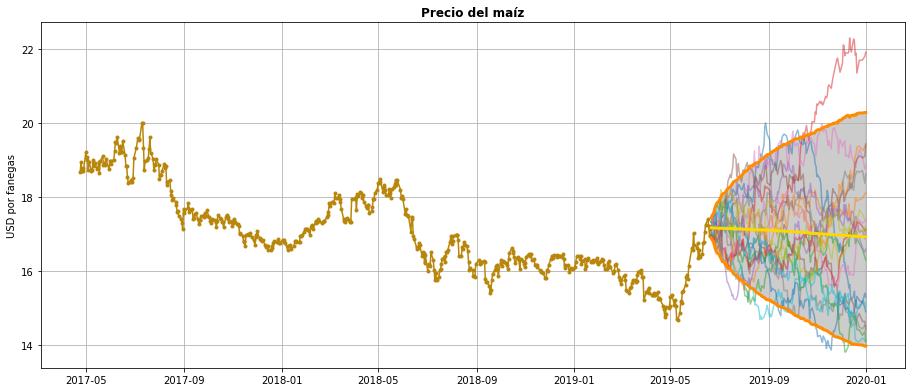

In [30]:
f7 = plt.figure(figsize=(15, 6))
ax7 = f7.add_axes([0.1,0.1,0.8,0.8])

ax7.set_facecolor('white')
ax7.plot(precio_maiz['Close'], linestyle='-', marker='.' ,color='darkgoldenrod')
ax7.plot(fechas,ma_sims[:,0:20], alpha=0.5)
plt.fill_between(fechas, ma_percentil05, ma_percentil95, where = ma_percentil05 <= ma_percentil95, color = 'grey', alpha = 0.4)
ax7.plot(fechas, ma_percentil05, color = 'darkorange', linewidth=3)
ax7.plot(fechas, ma_promedio, color = 'gold', linewidth=3)
ax7.plot(fechas, ma_percentil95, color = 'darkorange', linewidth=3)
ax7.set_ylabel('USD por fanegas')
ax7.set_title('Precio del maíz', fontweight='bold')
ax7.grid(True)

## Calcular promedios diarios mes a mes del precio del maíz

In [31]:
ma_sims_df =  pd.DataFrame(ma_sims, index = fechas).resample('M').mean()#.to_numpy()
ma_sims_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2019-06-30,17.404559,16.867170,17.127236,17.079128,17.224506,16.800774,17.304677,16.832317,17.651588,16.946990,...,17.235650,17.170088,17.122811,16.761633,17.097579,17.284106,16.872023,17.095886,16.961475,17.074026
2019-07-31,17.877711,16.143546,16.721165,16.523506,17.909922,17.403629,17.341010,16.799196,17.905831,16.215405,...,16.611733,18.284432,17.228639,16.515398,16.200086,17.102102,16.912958,16.608177,15.635423,17.307613
2019-08-31,18.738714,16.008928,15.491585,17.701972,18.402372,16.850160,18.792654,16.371936,17.157414,15.150527,...,16.902323,18.701740,17.239691,17.265825,15.292217,16.443627,18.002334,16.900379,14.641722,16.316782
2019-09-30,19.285591,17.450391,16.215580,17.850805,18.474323,16.633544,19.172061,15.836259,16.625347,15.112539,...,17.384594,18.990152,16.777591,18.408429,14.615482,16.368896,18.685497,17.417361,14.722776,14.415927
2019-10-31,19.388571,17.938577,16.606482,19.432933,18.143068,16.235777,19.332360,15.353711,16.742973,15.478943,...,17.844743,18.608992,17.466539,18.148674,14.690312,17.060804,17.814440,17.519761,14.828388,14.937159
2019-11-30,17.557487,17.709084,16.718840,21.010043,17.544904,15.874176,19.655392,15.036193,16.608064,15.136748,...,17.058169,19.722672,18.240517,18.491577,14.284888,16.828763,17.007479,17.612035,14.818925,15.121168
2019-12-31,15.610452,18.729280,16.754506,21.907142,17.348104,14.989848,19.124376,14.742605,17.098019,14.633560,...,16.768919,20.960757,18.859437,18.407979,13.910465,16.208227,16.503524,17.289781,14.987535,15.643633


## Tipo de cambio (MXN/USD)
El tipo de cambio se va a extraer usando pandas_datareader y extrayendo los datos de la página de la reserva federal de St. Louis (https://fred.stlouisfed.org/series/DEXMXUS).

In [32]:
import pandas_datareader as pdr
from pandas_datareader import data, wb

In [33]:
start_date_tc = datetime.datetime(2017, 1, 3)
end_date_tc = datetime.datetime(2019, 6, 20)
mxn_usd_tc = pdr.get_data_fred('DEXMXUS', start_date_tc, end_date_tc)

Text(0.5, 1.0, 'Tipo de cambio')

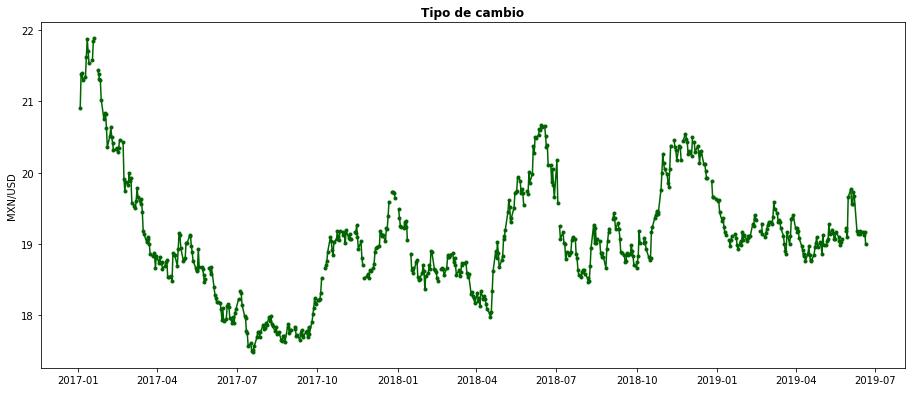

In [34]:
f4 = plt.figure(figsize=(15, 6))
ax4 = f4.add_axes([0.1,0.1,0.8,0.8])

ax4.set_facecolor('white')
ax4.plot(mxn_usd_tc, linestyle='-', marker='.' ,color='darkgreen')
ax4.set_facecolor('white')
ax4.set_ylabel('MXN/USD');
ax4.set_xlabel(' ');
ax4.set_title('Tipo de cambio', fontweight='bold')


In [35]:
mxn_usd_tc.describe()

,DEXMXUS
count,615.000000
mean,19.070850
std,0.811049
min,17.477500
25%,18.633000
50%,19.014500
75%,19.390250
max,21.891000


Text(0.5, 1.0, 'Histograma de las variaciones en tipo de cambio (MXN/USD: $\\mu=$-0.00018, $\\sigma=$0.0070')

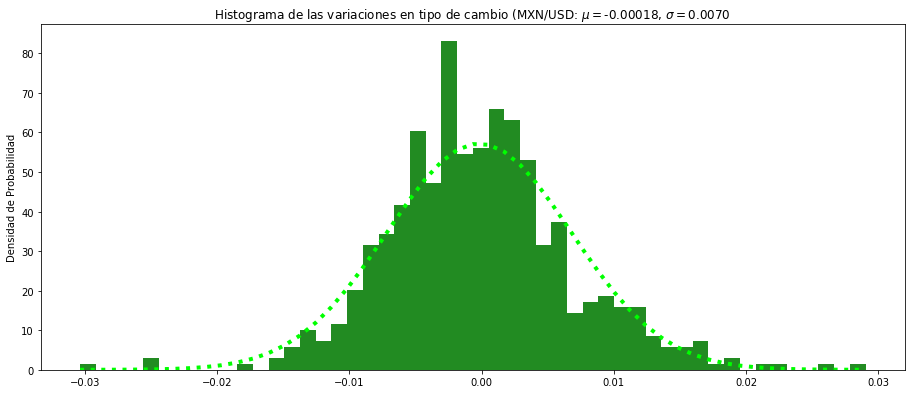

In [36]:
# Variaciones del tipo de cambio
# Crear variable de retornos e incluirla en el dataframe de pandas
tc_ret_log = pd.DataFrame()
tc_ret_log['delta_tc'] = np.log(mxn_usd_tc['DEXMXUS']).diff().dropna()

tc_retorno = tc_ret_log['delta_tc'].mean(); tc_retorno=  np.asscalar(tc_retorno)
tc_volatilidad = tc_ret_log['delta_tc'].std(); tc_volatilidad = np.asscalar(tc_volatilidad)

f5 = plt.figure(figsize=(15, 6))
ax5 = f5.add_axes([0.1,0.1,0.8,0.8])
ax5.set_facecolor('white')
n, bins, patches = ax5.hist(tc_ret_log['delta_tc'], 50, density=True, histtype='stepfilled', color='forestgreen')

tc_y = ((1 / (np.sqrt(2 * np.pi) * tc_volatilidad)) *
        np.exp(-0.5 * (1 / tc_volatilidad * (bins - tc_retorno))**2)) 

ax5.plot(bins, tc_y, ':', color='lime', linewidth='4')

ax5.set_xlabel('')
ax5.set_ylabel('Densidad de Probabilidad')
ax5.set_title('Histograma de las variaciones en tipo de cambio (MXN/USD: $\mu=$' +
             "{:,.5f}".format(tc_retorno) +', $\sigma=$' + "{:,.4f}".format(tc_volatilidad))

### Simulación del tipo de cambio
Al igual que en el caso anterior, la simulación del tipo de cambio (MXN/USD) se realiza con el siguiente modelo aleatorio. 
<br><br>
$$
TC_{i, sim} = \bar{TC} + X_{i} * vol_{tc}
$$
<br>
Donde $TC_{i, sim}$ es el tipo de cambio en el periodo $i$, $\bar{R}$ y $vol{ret}$, son el promedio y la volatilidad de las variaciones en la tasa de cambio, respectivamente. La variable $X_{i}$ se obtiene de draws aleatorios provenientes de la distrbiución normal estándar.

In [37]:
# arreglo de fechas
start = datetime.date(2019, 6, 20)
end = datetime.date(2019, 12, 31)
holidays = ['2019-12-24', datetime.date(2019, 12, 25), np.datetime64('2019-12-26')]
fechas = pd.bdate_range(start = start, end = end, freq = 'C', holidays = holidays)
fechas

# simulación de las variaciones en los precios de la soya
num_dias = len(fechas)
num_sims = 10000

## Definir Matriz de simulaciones
tc_sims = np.zeros((num_dias,num_sims))

## Definir Matriz de retornos aleatorios
tc_ret = np.random.randn(num_dias , num_sims) * tc_volatilidad + tc_retorno

## Definir el primer flujo como el ahorro inicial
tc_sims[0,] = np.exp(tc_ret[0,]) * mxn_usd_tc['DEXMXUS'].iloc[-1]


for i in range(1,num_dias):
    tc_sims[i,] = tc_sims[i-1,] * np.exp(tc_ret[i,])

In [38]:
tc_percentil05 = np.percentile(tc_sims,5,axis = 1)
tc_percentil95 = np.percentile(tc_sims,95,axis = 1)
tc_promedio = tc_sims.mean(axis = 1)

Text(0, 0.5, 'MXN/USD')

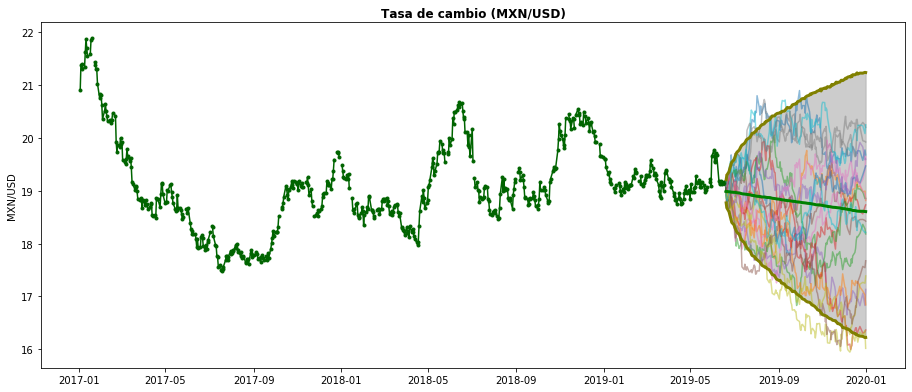

In [39]:
f6 = plt.figure(figsize=(15, 6))
ax6 = f6.add_axes([0.1,0.1,0.8,0.8])

ax6.set_facecolor('white')
ax6.plot(mxn_usd_tc['DEXMXUS'], linestyle='-', marker='.' ,color='darkgreen')
ax6.plot(fechas,tc_sims[:,0:20], alpha=0.5)
plt.fill_between(fechas, tc_percentil05, tc_percentil95, where = tc_percentil05 <= tc_percentil95, color = 'grey', alpha = 0.4)
ax6.plot(fechas, tc_percentil05, color = 'olive', linewidth=3)
ax6.plot(fechas, tc_promedio, color = 'green', linewidth=3)
ax6.plot(fechas, tc_percentil95, color = 'olive', linewidth=3)
ax6.set_title('Tasa de cambio (MXN/USD)', fontweight='bold')
ax6.set_ylabel('MXN/USD')

### Calcular promedios diarios mes a mes

In [40]:
tc_sims_df =  pd.DataFrame(tc_sims, index = fechas).resample('M').mean()#.to_numpy()
tc_sims_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2019-06-30,19.310150,19.127471,18.818509,18.818016,18.915312,19.293923,18.703968,18.848520,18.908997,19.334103,...,18.926973,18.711952,18.873478,19.143607,19.102059,18.680713,18.882403,18.752432,19.372167,19.016162
2019-07-31,19.649805,18.640527,17.992187,18.701338,18.188866,19.196505,18.245249,19.458321,18.708648,19.808970,...,18.654876,17.684545,18.851488,19.393444,18.628184,18.230468,18.586277,18.924987,19.781176,18.434700
2019-08-31,20.414824,18.184976,17.848175,18.675273,17.671455,18.666265,17.792661,20.228320,18.272361,20.056576,...,18.888631,17.252373,19.144764,19.723169,18.724166,17.239945,18.507296,18.478468,19.913283,17.994854
2019-09-30,20.306694,18.486248,17.375683,18.534283,17.752232,18.691298,18.000196,20.111768,17.076309,20.368149,...,18.471139,17.287873,18.535581,19.730865,18.276522,17.264886,18.571630,18.647999,19.858761,17.965130
2019-10-31,20.389817,19.341493,17.459218,17.823222,17.775827,18.449931,18.281161,20.008467,16.424861,20.289554,...,18.975306,17.778625,18.197476,20.017328,18.206178,17.472877,18.547818,18.978749,19.898202,18.087363


# Utilidades de las empresas

## Exportador de Soya

#### Definir variables

In [41]:
# producción (asumo que es USD X bushels (fanegas))

total_soya_prod = 5000 # en fanegas ¿Pueden producir siempre un número total de soya? ¿o también se simula?
# costos de producción (asumiendo que son determinísticos - no se simulan variaciones)
costo_fijo_soya = 4 # costo fijo de producir una fanegada de soya 
costo_vari_soya = 2 # costo variable de producir una fanegada de soya 
costo_total_soya = total_soya_prod*(costo_fijo_soya + costo_vari_soya)

**Obs:** Note que en este punto del ejercicio el choque de tasa de cambio afecta al total de ingresos sin diferenciar muy bien que son mercados diferentes el doméstico y el internacional. Si deseamos ajustar esto debemos incluir los precios domésticos de la soya en MXN.

#### Definir utilidades del exportador de soya

Utilidadesen MXN


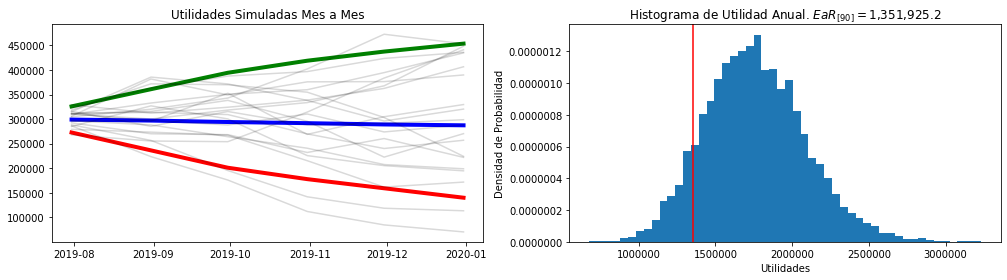

In [42]:
# ingresos 
precios_sim_prom = sims_df.shift(1).dropna().loc['2019-6-20':'2019-12-31']
tc_sim_prom = tc_sims_df.shift(1).dropna().loc['2019-6-20':'2019-12-31']

ing_tot_USD = (total_soya_prod)*precios_sim_prom
ing_tot_MXN = ing_tot_USD*tc_sim_prom

# Utilidades
sim_utils_USD = (ing_tot_USD - costo_total_soya).loc['2019-6-20':'2019-12-31']
sim_utils_MXN = (tc_sim_prom*(ing_tot_USD - costo_total_soya)).loc['2019-6-20':'2019-12-31']

print('Utilidades en MXN para el productor de soya')
graficar_percentiles_df(sim_utils_MXN)

## Exportador de Maíz

In [47]:
# producción (asumo que es USD X bushels (fanegas))

total_maiz_prod = 5000 # en fanegas ¿Pueden producir siempre un número total de soya? ¿o también se simula?
costo_fijo_maiz = 7 # costo fijo de producir una fanegada de soya 
costo_vari_maiz = 4 # costo variable de producir una fanegada de soya 
costo_total_maiz = total_maiz_prod*(costo_fijo_maiz + costo_vari_maiz)

Utilidades en MXN para el productor de maíz


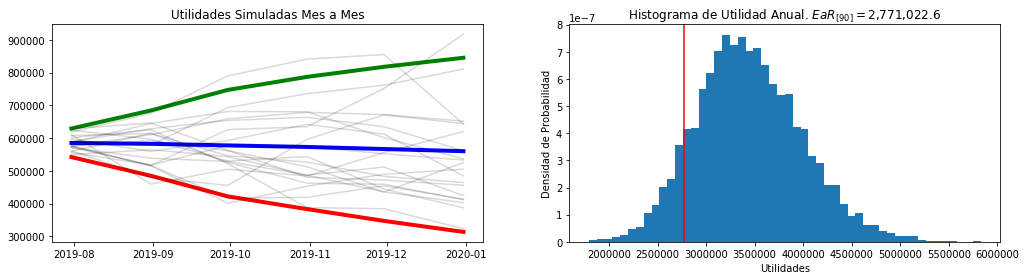

In [50]:
# ingresos 
ma_precios_sim_prom = ma_sims_df.shift(1).dropna().loc['2019-6-20':'2019-12-31']

ma_ing_tot_USD = (total_maiz_prod)*ma_precios_sim_prom
ma_ing_tot_MXN = ma_ing_tot_USD*tc_sim_prom

# Utilidades
ma_sim_utils_USD = (ma_ing_tot_USD - costo_total_maiz).loc['2019-6-20':'2019-12-31']
ma_sim_utils_MXN = (tc_sim_prom*(ma_ing_tot_USD - costo_total_maiz)).loc['2019-6-20':'2019-12-31']

print('Utilidades en MXN para el productor de maíz')
graficar_percentiles_df(ma_sim_utils_MXN)